In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('../../../../')
print(os.getcwd())
from v2.strategy.indicators.optimal_v2 import Optimal_v2
from v2.model import Trading
from v2.strategy.indicators.param import Param
from v2.strategy.indicators.roc import RateOfChange
from v2.research.scripts.notebook_utils import notebookUtils
from v2.research.scripts.scoreboard import updateScoreboard
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance


/Users/rosscopeland/Desktop/personal/code/vivaldi/back_testing


In [2]:
nu = notebookUtils()
model_name = "CLASSIFICATION_CHANGE_THIS"

In [3]:
dataset, features, indicators = nu.loadData(indicators=[('rsi', 'close'), ('optimal_v2', 'close')],
                            param_spec={},
                            optimal_threshold={'buy':0.8},
                            spans=[{'indicator_name':'willr',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]},
                                    {'indicator_name':'cci',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]},
                                    {'indicator_name':'rsi',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]},
                                    {'indicator_name':'momentum',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]},
                                    {'indicator_name':'roc',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]},
                                    {'indicator_name':'momentum',
                                    'column_name': 'RSI',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]},
                                    {'indicator_name':'roc',
                                    'column_name': 'RSI',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]}
                                    ],

                            scale='minmaxwindow')
        
    # create one minute, five minute, ten minute, and twenty minute slopes for macd, rsi




Loading data from BTC...
Loading data from chunk 0...
Loading data from chunk 1...


In [4]:
edit_dataset = dataset.drop(["time", "open", "high", "low", 'volume'], axis=1)
edit_dataset.dropna(inplace=True)
edit_dataset

,close,RSI,optimal,WILLR_close_period_3,WILLR_close_period_5,WILLR_close_period_10,WILLR_close_period_30,CCI_close_period_3,CCI_close_period_5,CCI_close_period_10,...,RateOfChange_close_period_10,RateOfChange_close_period_30,Momentum_RSI_period_3,Momentum_RSI_period_5,Momentum_RSI_period_10,Momentum_RSI_period_30,RateOfChange_RSI_period_3,RateOfChange_RSI_period_5,RateOfChange_RSI_period_10,RateOfChange_RSI_period_30
15089,8855.729165,0.465935,0.0,0.521125,0.859733,0.855828,0.612806,1.000000,0.707136,0.679221,...,0.453607,0.485480,0.596747,0.687635,0.623075,0.484434,0.609041,0.661572,0.572975,0.449526
15090,8855.894583,0.449259,0.0,0.515805,0.781733,0.850489,0.615702,1.000000,0.784119,0.667827,...,0.480097,0.485445,0.555441,0.664282,0.660540,0.477490,0.560025,0.627372,0.624898,0.442646
15091,8859.017291,0.470618,0.0,0.658184,0.701051,0.904315,0.670390,0.897075,0.803206,0.641574,...,0.501499,0.489307,0.587560,0.614055,0.682878,0.492007,0.597619,0.551741,0.654248,0.457303
15092,8857.393646,0.448464,0.0,0.432220,0.606172,0.867634,0.641955,0.123588,0.589511,0.600528,...,0.498913,0.485198,0.523280,0.575824,0.644808,0.469178,0.523130,0.501088,0.603051,0.434083
15093,8860.301823,0.474313,0.0,0.642688,0.776113,0.933334,0.692886,0.850744,0.794162,0.609938,...,0.504866,0.493728,0.578827,0.605790,0.663742,0.509127,0.587026,0.540270,0.626694,0.475416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315232,18519.207620,0.456972,0.0,0.519744,0.428394,0.126793,0.031906,0.863859,0.392106,0.374346,...,0.606396,0.596548,0.578584,0.565483,0.502199,0.235076,0.501016,0.508435,0.375851,0.173065
315233,18523.983810,0.471670,0.0,0.201420,0.200015,0.221838,0.088531,1.000000,1.000000,0.588887,...,0.610412,0.597902,0.624840,0.567331,0.518435,0.273425,0.539331,0.509864,0.390231,0.196494
315234,18525.301905,0.467947,0.0,0.232852,0.231499,0.252022,0.102116,0.520601,0.629556,0.516987,...,0.621583,0.602735,0.619499,0.576487,0.566444,0.306899,0.534936,0.517413,0.432292,0.215707
315235,18526.950952,0.471514,0.0,0.272175,0.270887,0.289785,0.119112,0.218565,0.561493,0.525494,...,0.627825,0.601871,0.610117,0.599404,0.570310,0.287385,0.526956,0.536459,0.435807,0.204548


In [5]:
trainX, testX, trainy, testy = nu.splitData(edit_dataset, split_size=0.2, y_column_name="optimal", shuffle_data=False, balance_unbalanced_data=True, balance_info={'multiplier_val':4, 'superset_class_val':0, 'randomize_concat':True})
trainX

,close,RSI,WILLR_close_period_3,WILLR_close_period_5,WILLR_close_period_10,WILLR_close_period_30,CCI_close_period_3,CCI_close_period_5,CCI_close_period_10,CCI_close_period_30,...,RateOfChange_close_period_10,RateOfChange_close_period_30,Momentum_RSI_period_3,Momentum_RSI_period_5,Momentum_RSI_period_10,Momentum_RSI_period_30,RateOfChange_RSI_period_3,RateOfChange_RSI_period_5,RateOfChange_RSI_period_10,RateOfChange_RSI_period_30
0,11958.965026,0.535182,0.731253,0.138186,0.041727,0.135150,4.201821e-01,0.316407,0.356723,0.496848,...,0.723394,0.682474,0.653153,0.644402,0.568026,0.631778,0.433937,0.409114,0.330517,0.314816
1,10248.346789,0.476399,0.352641,0.339556,0.281631,0.049810,1.289022e-01,0.203170,0.227612,0.348953,...,0.724550,0.643035,0.472413,0.481115,0.510234,0.290693,0.444591,0.441726,0.390155,0.242443
2,9317.930323,0.684514,0.599788,0.633964,0.767729,0.883590,9.732604e-01,0.808430,0.666583,0.659053,...,0.786229,0.726603,0.623170,0.522671,0.620908,0.598513,0.321079,0.244895,0.283626,0.240625
3,9629.540491,0.448981,0.490767,0.443179,0.204005,0.110310,4.585361e-01,0.346925,0.393274,0.498247,...,0.643396,0.588286,0.689447,0.675870,0.619341,0.566275,0.592232,0.478819,0.347485,0.309440
4,11372.877912,0.398890,0.857511,0.601177,0.406098,0.878430,5.652105e-01,0.528406,0.430808,0.416346,...,0.370331,0.475985,0.332458,0.399126,0.450183,0.470967,0.382501,0.428152,0.457619,0.427741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36545,9202.971273,0.421440,0.506507,0.348528,0.344854,0.584680,2.276636e-11,0.075909,0.282009,0.581338,...,0.659256,0.610200,0.461364,0.499353,0.556258,0.563089,0.394700,0.339780,0.398794,0.362936
36546,10988.506900,0.422527,0.653870,0.364920,0.311969,0.703579,1.833115e-11,0.107066,0.244220,0.595458,...,0.490546,0.428633,0.513373,0.452471,0.486080,0.477459,0.463052,0.360304,0.438584,0.442838
36547,11793.975385,0.508547,0.392871,0.625457,0.707708,0.813657,9.275851e-12,0.574961,0.626359,0.570704,...,0.459384,0.559482,0.532622,0.570085,0.503828,0.567434,0.456381,0.481561,0.419468,0.536115
36548,9378.671923,0.535142,0.804649,0.888655,0.890491,0.947838,7.416265e-02,0.228883,0.470164,0.586250,...,0.673372,0.694559,0.557913,0.495315,0.588012,0.646737,0.435796,0.346439,0.401284,0.393888


In [6]:
class_weights = nu.getWeights(trainy)
class_weights

{0: 0.625, 1: 2.5}

In [7]:
testX

,close,RSI,WILLR_close_period_3,WILLR_close_period_5,WILLR_close_period_10,WILLR_close_period_30,CCI_close_period_3,CCI_close_period_5,CCI_close_period_10,CCI_close_period_30,...,RateOfChange_close_period_10,RateOfChange_close_period_30,Momentum_RSI_period_3,Momentum_RSI_period_5,Momentum_RSI_period_10,Momentum_RSI_period_30,RateOfChange_RSI_period_3,RateOfChange_RSI_period_5,RateOfChange_RSI_period_10,RateOfChange_RSI_period_30
255243,11642.020958,0.507111,0.955932,0.279228,0.210132,0.222110,2.498866e-01,0.249961,0.289324,0.304812,...,0.302785,0.439882,0.268999,0.253304,0.319164,0.340717,0.350477,0.327303,0.378643,0.371766
255244,11631.360479,0.466460,0.954178,0.192955,0.155122,0.168167,2.056645e-11,0.173892,0.281179,0.245567,...,0.268689,0.420447,0.249728,0.201813,0.288875,0.293959,0.331666,0.283888,0.351550,0.332665
255245,11632.605240,0.491264,0.960952,0.363683,0.235651,0.247133,1.852333e-01,0.222627,0.323493,0.243640,...,0.258195,0.422342,0.336950,0.258489,0.302284,0.321115,0.407970,0.329996,0.364371,0.355467
255246,11629.072620,0.473340,0.968804,0.425478,0.240824,0.229945,2.103619e-11,0.257199,0.346458,0.245123,...,0.238746,0.409935,0.298498,0.269867,0.275136,0.288777,0.373179,0.337692,0.342314,0.329748
255247,11628.821310,0.479032,0.972973,0.418238,0.264058,0.226250,7.245054e-01,0.375021,0.384558,0.271881,...,0.244124,0.402922,0.361933,0.328554,0.309759,0.287692,0.431464,0.388525,0.368742,0.329664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315232,18519.207620,0.456972,0.519744,0.428394,0.126793,0.031906,8.638590e-01,0.392106,0.374346,0.457764,...,0.606396,0.596548,0.578584,0.565483,0.502199,0.235076,0.501016,0.508435,0.375851,0.173065
315233,18523.983810,0.471670,0.201420,0.200015,0.221838,0.088531,1.000000e+00,1.000000,0.588887,0.498162,...,0.610412,0.597902,0.624840,0.567331,0.518435,0.273425,0.539331,0.509864,0.390231,0.196494
315234,18525.301905,0.467947,0.232852,0.231499,0.252022,0.102116,5.206006e-01,0.629556,0.516987,0.488539,...,0.621583,0.602735,0.619499,0.576487,0.566444,0.306899,0.534936,0.517413,0.432292,0.215707
315235,18526.950952,0.471514,0.272175,0.270887,0.289785,0.119112,2.185646e-01,0.561493,0.525494,0.492946,...,0.627825,0.601871,0.610117,0.599404,0.570310,0.287385,0.526956,0.536459,0.435807,0.204548


In [8]:
clf = RandomForestClassifier(random_state=69420, class_weight=class_weights, n_jobs=-1, n_estimators=100, criterion='gini', min_samples_leaf=2)
clf.fit(trainX.drop("close", axis=1).values, trainy.values)

print(clf.score(testX.drop("close", axis=1).values, testy.values))

# feature_importances = permutation_importance(clf, trainX.drop("close", axis=1).values, trainy.values, n_repeats=10, random_state=69420)

# for i in range(len(feature_importances.importances_mean)):
#     print('i: {}, Feature: {}, Score: {}'.format(i, trainX.drop("close", axis=1).columns[i], feature_importances.importances_mean[i]))

0.9016901690169017


In [9]:
reduced_classified_data = nu.classifyPoints([clf], testX, predict_proba=False, proba_thresh=[0.6], plot_optimal=True, optimal=testy)

In [10]:
smaller_view_data = reduced_classified_data[1000:2000]
smaller_view_data.reset_index(inplace=True)

<Figure size 432x288 with 0 Axes>

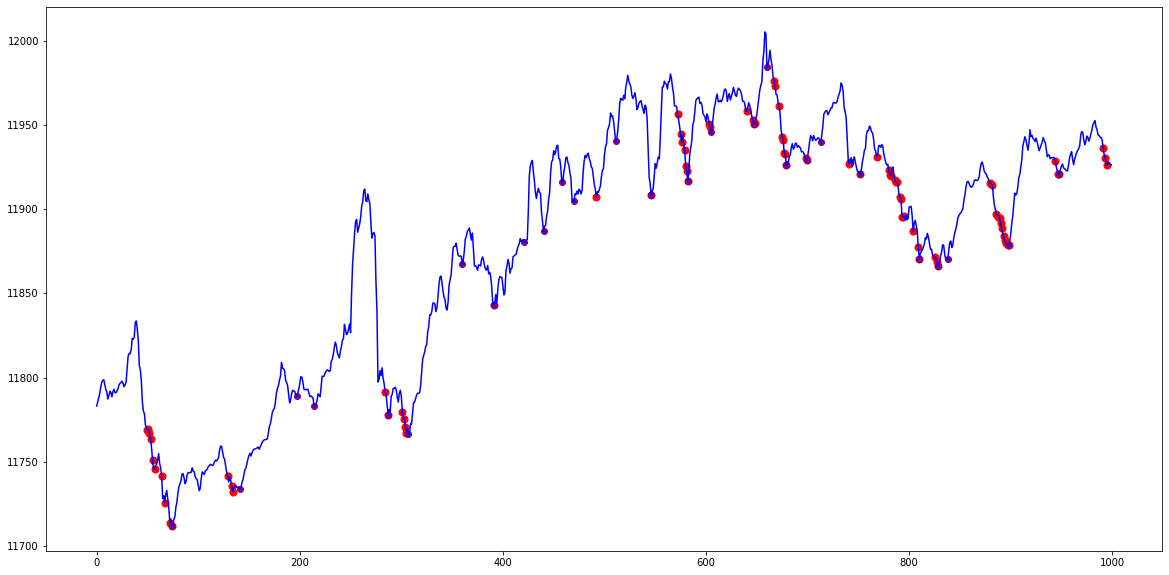

In [11]:
nu.graphPoints(smaller_view_data, mode="buy", plot_optimal=True)

In [16]:
nu.exportProductionModel(clf, model_name, new_version=False, indicators=indicators, features=features, proba_threshold=0.0, is_nn=False)

{'RSIdefault': {}, 'WILLR': {'close': {}}}
{'RSIdefault': {}, 'WILLR': {'close': {'period': {10.0, 3.0, 5.0, 30.0}}}, 'CCI': {'close': {}}}
{'RSIdefault': {}, 'WILLR': {'close': {'period': {10.0, 3.0, 5.0, 30.0}}}, 'CCI': {'close': {'period': {10.0, 3.0, 5.0, 30.0}}}, 'RSI': {'close': {}}}
{'RSIdefault': {}, 'WILLR': {'close': {'period': {10.0, 3.0, 5.0, 30.0}}}, 'CCI': {'close': {'period': {10.0, 3.0, 5.0, 30.0}}}, 'RSI': {'close': {'period': {10.0, 3.0, 5.0, 30.0}}}, 'Momentum': {'close': {}}}
{'RSIdefault': {}, 'WILLR': {'close': {'period': {10.0, 3.0, 5.0, 30.0}}}, 'CCI': {'close': {'period': {10.0, 3.0, 5.0, 30.0}}}, 'RSI': {'close': {'period': {10.0, 3.0, 5.0, 30.0}}}, 'Momentum': {'close': {'period': {10.0, 3.0, 5.0, 30.0}}}, 'RateOfChange': {'close': {}}}
{'RSIdefault': {}, 'WILLR': {'close': {'period': {10.0, 3.0, 5.0, 30.0}}}, 'CCI': {'close': {'period': {10.0, 3.0, 5.0, 30.0}}}, 'RSI': {'close': {'period': {10.0, 3.0, 5.0, 30.0}}}, 'Momentum': {'close': {'period': {10.0, 3.0

'0_1'

In [19]:
import pickle
pickle.load(open('production_models/CLASSIFICATION_CHANGE_THIS/0_1/CLASSIFICATION_CHANGE_THIS_0_1.sav', 'rb'))

{'proba_threshold': 0.0,
 'model': RandomForestClassifier(class_weight={0: 0.625, 1: 2.5}, min_samples_leaf=2,
                        n_jobs=-1, random_state=69420),
 'features': {'RSIdefault': {},
  'WILLR': {'close': {'period': {3.0, 5.0, 10.0, 30.0}}},
  'CCI': {'close': {'period': {3.0, 5.0, 10.0, 30.0}}},
  'RSI': {'close': {'period': {3.0, 5.0, 10.0, 30.0}}},
  'Momentum': {'close': {'period': {3.0, 5.0, 10.0, 30.0}},
   'RSI': {'period': {3.0, 5.0, 10.0, 30.0}}},
  'RateOfChange': {'close': {'period': {3.0, 5.0, 10.0, 30.0}},
   'RSI': {'period': {3.0, 5.0, 10.0, 30.0}}}}}

In [13]:
model_version = nu.exportModel(clf, model_name, new_version=False, indicators=indicators, features=features, proba_threshold=0.0, is_nn=False)

In [14]:
score, trades = nu.testModel(model_name)

Importing Strategies...
Generating Model Data...
Scaling Model Data...
Preprocessing Model Predictions...
0it [00:00, ?it/s]Generating Algo Data...
Executing Strategy...
105553it [00:00, 311204.92it/s]
Generating Report...


In [15]:
updateScoreboard(model_name, model_version, score, trades, features)